In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import joblib
import seaborn as sns
import nltk
from collections import Counter


#Loading the data
x_train=pd.read_csv('../data/processed/x_train.csv',delimiter=',')
y_train=pd.read_csv('../data/processed/y_train.csv',delimiter=',')

#Removing the date, title and subject columns in order to avoid perfect prediction
# x_train["day"] = pd.to_datetime(x_train["date"]).dt.day
# x_train["month"] = pd.to_datetime(x_train["date"]).dt.month
# x_train["year"] = pd.to_datetime(x_train["date"]).dt.year

#in order to get perfect predection dont drop the subject column
#and in preprocessing uncomment the subject and date
x_train=x_train.drop(columns=['date','title','subject'])

#Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42)

print(x_train.head())
print(y_train.head())


                                                    text
36335  nairobi reuter dramat pictur kenyan opposit la...
12384  outspoken liber comedian pose photo shoot cont...
24419  washington reuter two lawmak question whether ...
24740  new york reuter facebook inc chief execut mark...
27039  month rampant specul trump russian collus alle...
       label
36335      1
12384      0
24419      1
24740      1
27039      0


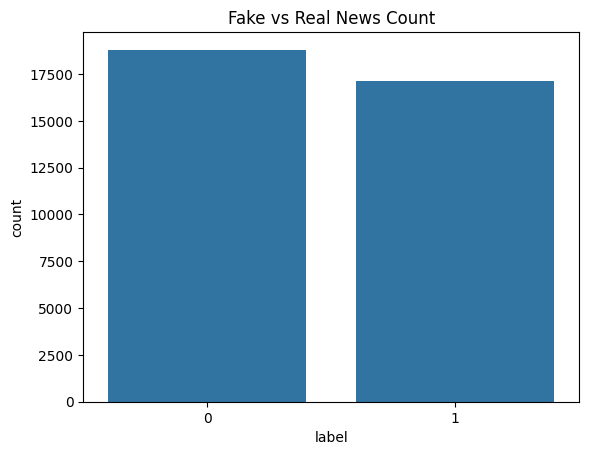

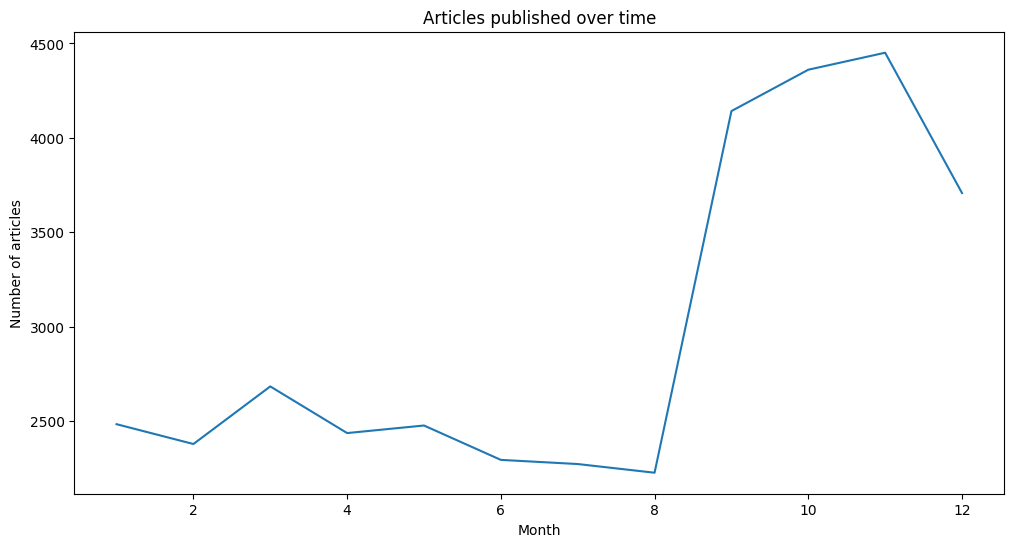

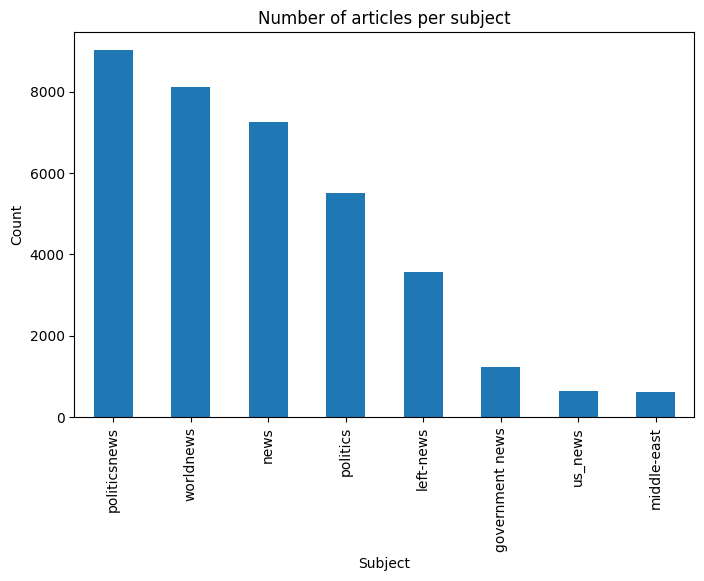

In [4]:
#Visualizing the distribution of labels in the training set
sns.countplot(x='label', data=y_train)
plt.title("Fake vs Real News Count")
plt.show()


#Visualizing the number of articles published over time
x_train.groupby(x_train['month']).size().plot(kind="line", figsize=(12,6))

plt.title("Articles published over time")
plt.xlabel("Month")
plt.ylabel("Number of articles")
plt.show()

#Visualizing the distribution of subjects in the training set
x_train['subject'].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Number of articles per subject")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.show()


In [2]:
#Building a preprocessing and modeling pipeline
text_features = 'text'
date_features = ['day', 'month', 'year']
subject_features = 'subject'
preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7,ngram_range=(1,3), max_features=5000), text_features),
    #('date', 'passthrough', date_features),
    #('subject', OneHotEncoder(handle_unknown='ignore'), [subject_features])
])

LogisticRegressionModel=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000,random_state=42))
])

LogisticRegressionModel.fit(x_train, y_train.values.ravel())
y_pred = LogisticRegressionModel.predict(x_val)

print("Logistic Regression Model")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

Logistic Regression Model
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4685
           1       0.98      0.99      0.99      4295

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion Matrix:
[[4600   85]
 [  40 4255]]
Accuracy: 0.9860801781737194


In [3]:
#Building the Random Forest Classifier model
RandomForestModel=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1))
])

RandomForestModel.fit(x_train, y_train.values.ravel())

y_pred = RandomForestModel.predict(x_val)

#Evaluating the Random Forest Classifier model
print("Random Forest Classifier Model")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

Random Forest Classifier Model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4685
           1       1.00      1.00      1.00      4295

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Confusion Matrix:
[[4675   10]
 [   8 4287]]
Accuracy: 0.9979955456570155


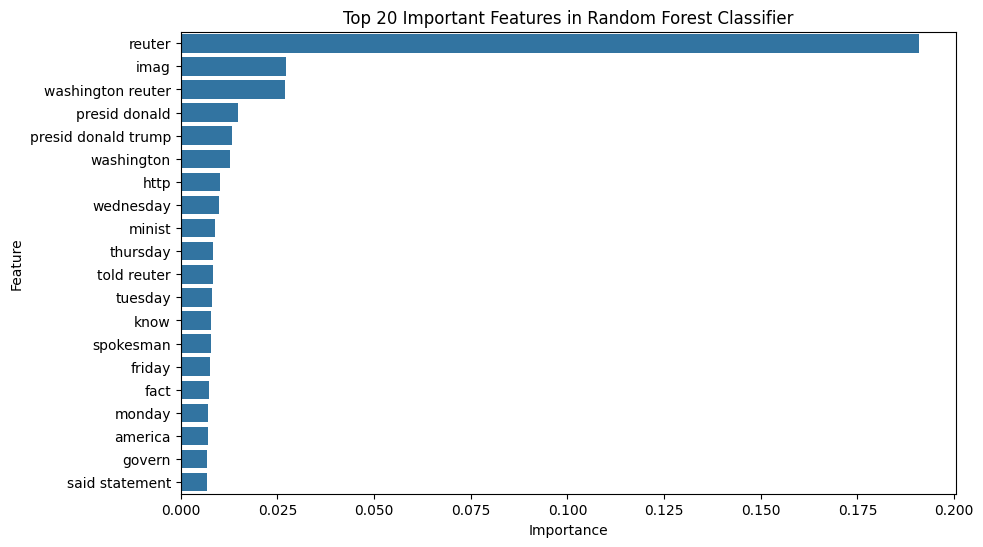

In [4]:
tfidf=LogisticRegressionModel.named_steps['preprocessor'].named_transformers_['tfidf']
feature_names=tfidf.get_feature_names_out()

importances=RandomForestModel.named_steps['classifier'].feature_importances_
feature_importance_df=pd.DataFrame({'feature':feature_names,'importance':importances})
feature_importance_df=feature_importance_df.sort_values(by='importance',ascending=False).head(20)

#visualizing the top 20 important features
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title("Top 20 Important Features in Random Forest Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
#Building the XGBoost Classifier model
XGBoostModel=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

XGBoostModel.fit(x_train, y_train.values.ravel())

y_pred = XGBoostModel.predict(x_val)

#Evaluating the XGBoost Classifier model
print("XGBoost Classifier Model")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))